<a href="https://colab.research.google.com/github/YonghwanYim/Agent_Based_Model_Transport_System/blob/master/2018_11_26_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Drive 연동, 파일 생성**

In [0]:
!pip install -U -q PyDrive # Google Drive 인증
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# mnist.py
temp = drive.CreateFile({'id' : '1hPFSjrJOnbuWtSZguJy-tNgsq0nlGs64'}) # Generate File
temp.GetContentFile('mnist.py') # Rename
# functions.py
temp = drive.CreateFile({'id' : '1QMzKrvnRBH-AbvnUJhB4MJYldhzUt2tY'}) # Generate File
temp.GetContentFile('functions.py') # Rename
# gradient.py
temp = drive.CreateFile({'id' : '1-fV8DtnDHd-evmHGDOBNiNZWxW-YK4v1'}) # Generate File
temp.GetContentFile('gradient.py') # Rename
# layers.py
temp = drive.CreateFile({'id' : '1tEvPr0PVrWF2wOrfWyNEKstNibn5LJMd'}) # Generate File
temp.GetContentFile('layers.py') # Rename
# multilayernet.py
temp = drive.CreateFile({'id' : '1Ft_iIP9WVejT5YgbQnX6lkudpY-XHKQZ'}) # Generate File
temp.GetContentFile('multilayernet.py') # Rename
# multilayernetextend.py
temp = drive.CreateFile({'id' : '1-fM0bu1aAPtx0se-biRJzSv-v9WgahDh'}) # Generate File
temp.GetContentFile('multilayernetextend.py') # Rename
# optimizer.py
temp = drive.CreateFile({'id' : '1EGIbur6m0_mklzqKV-tiszOupE_SrCMX'}) # Generate File
temp.GetContentFile('optimizer.py') # Rename
# trainer.py
temp = drive.CreateFile({'id' : '1PPDabIzpLbmLHBzQ1suW006hTyOxU-Bi'}) # Generate File
temp.GetContentFile('trainer.py') # Rename
# util.py
temp = drive.CreateFile({'id' : '1t-3l-Kj2FAIHaH0yCGnhXx5tZnZ_Hy8H'}) # Generate File
temp.GetContentFile('util.py') # Rename

!ls # 생성된 파일 확인

adc.json      layers.py		      multilayernet.py	trainer.py
functions.py  mnist.py		      optimizer.py	util.py
gradient.py   multilayernetextend.py  sample_data


# **Convolutional Neural Network**

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.2990454404312652
=== epoch:1, train acc:0.204, test acc:0.215 ===
train loss:2.2958306091964182
train loss:2.2911928434028037
train loss:2.2796281674418997
train loss:2.274052230327574
train loss:2.2545091845877874
train loss:2.2564803686216006
train loss:2.2335874377172256
train loss:2.193603037684353
train loss:2.1537326843207247
train loss:2.1124844012840707
train loss:2.106646328092552
train loss:2.0365081254786834
train loss:2.0076006918095564
train loss:1.9762636038900285
train loss:1.9424328191491964
train loss:1.7029482307021313
train loss:1.684289702036786
train loss:1.699340690801992
train loss:1.5673416144367005
train loss:1.5133046473696452
train loss:1.385154429552326


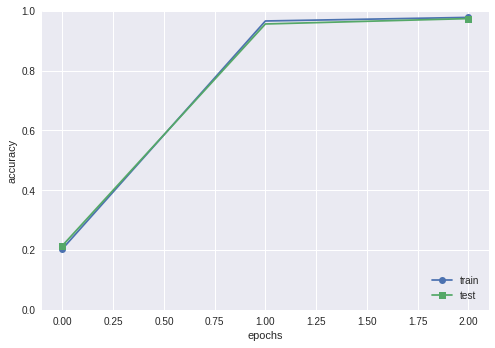

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  
import pickle
import numpy as np
from collections import OrderedDict
from layers import *
from gradient import numerical_gradient
import matplotlib.pyplot as plt
from mnist import load_mnist
from trainer import Trainer


class SimpleConvNet:
   
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)


#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 3   #20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()


network.save_params("params.pkl")
print("Saved Network Parameters!")


markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [4]:
!ls # params.pkl

adc.json      multilayernetextend.py  t10k-images-idx3-ubyte.gz
functions.py  multilayernet.py	      t10k-labels-idx1-ubyte.gz
gradient.py   optimizer.py	      trainer.py
layers.py     params.pkl	      train-images-idx3-ubyte.gz
mnist.pkl     __pycache__	      train-labels-idx1-ubyte.gz
mnist.py      sample_data	      util.py
